In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
# License: MIT

In [3]:
%matplotlib inline

## Packages

In [4]:
import numpy as np
import scipy as scipy
import scipy.stats as stats
import scipy.linalg as linalg
from pprint import pprint

import matplotlib.gridspec as gridspec
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import sys
import os
import copy
import string
import glob
import xarray as xr 

import warnings

## Modules

In [5]:
from custom_functions import *

# Define function

In [6]:
def DuffODE(t,x,p):
    '''2D ODE system exhibiting relaxation oscillations
    Input
    ----------
    t : float
        time value
    x : array (3, N)
        state space values
    p : array (5,)
        parameter values
    Returns
    -------
    xout : array, shape (3, N)
           Array containing derivative at x
           2nd dimension denotes derivatives for different points
    '''

    if x.ndim == 1:
        x = np.expand_dims(x, axis=1)
    
    n = x.shape
    xout = np.empty(n)
    xout[:] = np.nan 
    
    alpha = p[0,]
    delta = p[1,]
    beta = p[2,]
    K = p[3,]
    omega = p[4,]
    
    xout[0,:] = x[1,:];
    xout[1,:] = -alpha*x[0,:]-delta*x[1,:]-beta*x[0,:]**3+K*np.cos(omega*t);
    
    return xout

# Set parameters

In [17]:
# α = 1,    𝛿 = 0,   β = 0,   K = 0.5,    ω = 0.5       P
# α = 1,    𝛿 = 0,   β = 0,   K = 0.5,    ω = 0.5       P
# α = 1,    𝛿 = 0,   β = 0,   K = 0.5,    ω = sqrt(2)   QP
# α = 1,    𝛿 = 0,   β = 1,   K = 0.5,    ω = 0.5       QP
# α = 1,    𝛿 = 1,   β = 0,   K = 0.5,    ω = 0.5       P
# α = 1,    𝛿 = 1,   β = 1,   K = 10,     ω = 1.2       Chaos

alpha = 1. # stiffness
delta = 0. # linear damping
beta = 0. # nonlinearity
K = 0.5 # forcing strength
omega = 1.2 # frequency

p = np.array([alpha,delta,beta,K,omega])

# Solve IVP

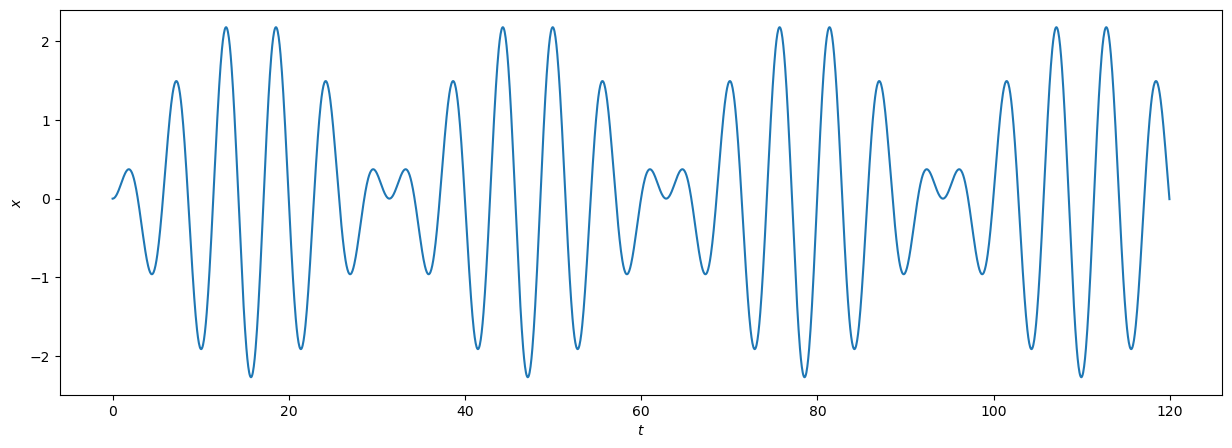

In [18]:
x1 = 0.
x2 = 0.

# Set up for initial value problem solver
x0 = np.array([x1,x2])
tspan = [0,120]
timescale = 2/omega*np.pi
h = 0.01*timescale

# Solve the ODE
[X,t,xeq1] = MyIVP(lambda t,x:DuffODE(t,x,p),x0,tspan,h)

plt.figure(figsize=(15,5))
plt.plot(t,X[0,:].T)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

# Plot Poincare map

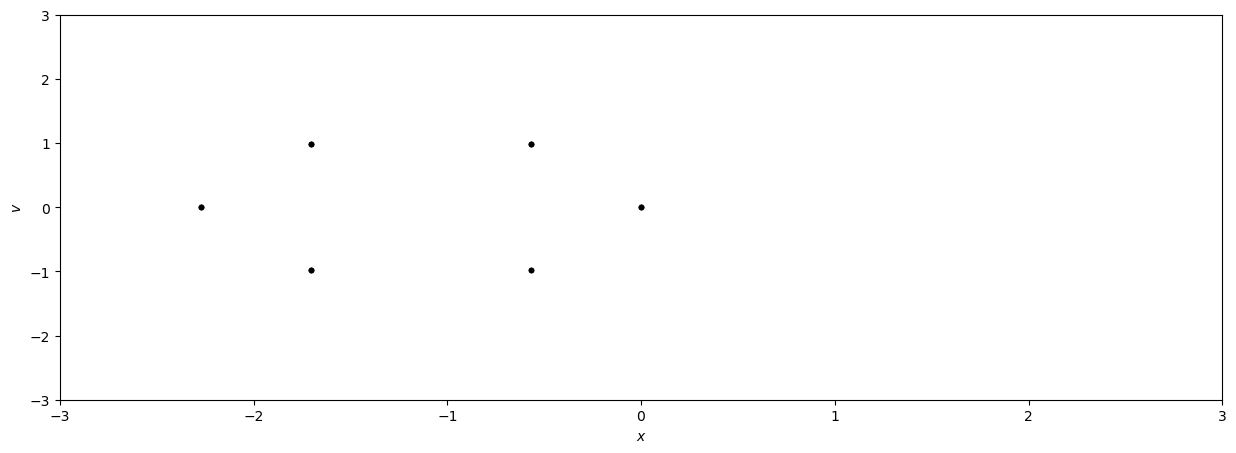

In [19]:
plt.figure(figsize=(15,5))
plt.plot(X[0,0,::100],X[1,0,::100],'k.')
plt.xlabel('$x$')
plt.ylabel('$v$')
plt.axis([-3,3,-3,3])
plt.show()

# Plot 3D trajectory

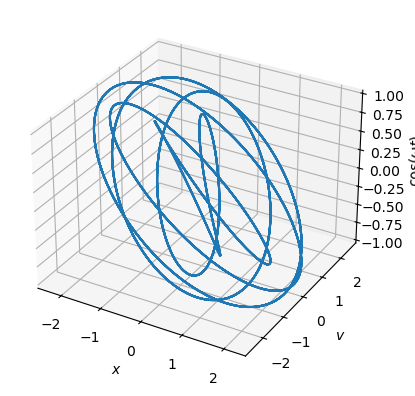

In [20]:
ax = plt.figure().add_subplot(111,projection='3d')
ax.plot3D(np.squeeze(X[0,:]),np.squeeze(X[1,:]),np.squeeze(np.cos(omega*t)))
ax.set_xlabel('$x$')
ax.set_ylabel('$v$')
ax.set_zlabel('$\\cos(\omega t)$')
plt.show()

# Calculate Lyapunov exponents

In [21]:
hjac = 1e-6
Js = MyJacobian(lambda x:DuffODE(0,x,p),np.squeeze(X),hjac)
M = np.empty(np.shape(Js))*np.nan
for j in np.arange(0,np.shape(Js)[2]):
    M[:,:,j] = linalg.expm(Js[:,:,j]*h)

N = X.shape[2]

lams,Rdiag,Lambda,xout = LyapQR(M,x0,N,h=h)
print(lams)

[ 5.81275638e-13 -5.81025747e-13]


# Calculate frequency spectrum

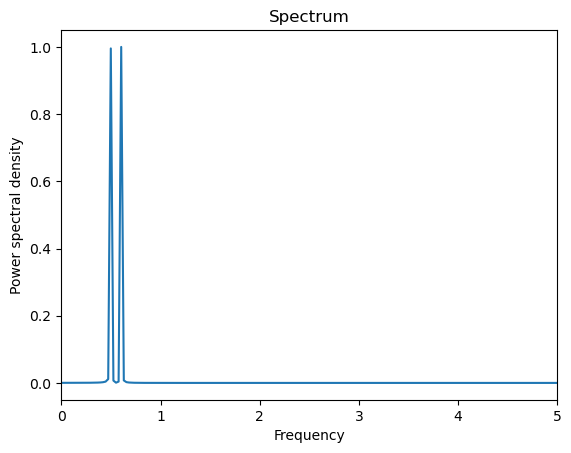

In [22]:
N = X.shape[2]
fs = 1/h
xdft = scipy.fftpack.fft(X[0,:])
xdft = xdft[:int((N+1)/2)]
psdx = (1/(fs*N)) * abs(xdft)**2
psdx[1:] = 2*psdx[1:]
freq = np.linspace(0,fs/2+fs/N,N)

plt.plot(freq*2*np.pi,(psdx/np.max(psdx)).T)
plt.title("Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Power spectral density")
plt.xlim([0,5])
plt.show()